# Notebook 4: Bayesian Bandits

[Bayesian Decision Analysis](https://allendowney.github.io/BayesianDecisionAnalysis/)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

In the previous notebook we solved the Euro problem, which involved estimating the proportion of heads we get when we spin a coin on edge.

In this notebook we solve the Bayesian bandit problem, which is similar in the sense that it involves estimating proportions, but different in the sense that we use the posterior distribution as part of a decision-making process.

## The Bayesian bandit problem

Suppose you have several "one-armed bandit" slot machines, and there's reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

First, let's see how to do the update.

## The prior

If we know nothing about the probability of wining, we can start with a uniform prior.

In [2]:
def make_pmf(qs, ps, **options):
    """Make a Series that represents a PMF.
    
    qs: sequence of quantities
    ps: sequence of probabilities
    options: keyword arguments passed to Series constructor
    
    returns: Pandas Series
    """
    pmf = pd.Series(ps, index=qs, **options)
    return pmf

In [3]:
xs = np.arange(101)
prior = make_pmf(xs, 1/101)

In [4]:
def decorate_bandit(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of winning')
    plt.ylabel('PMF')
    plt.title(title)

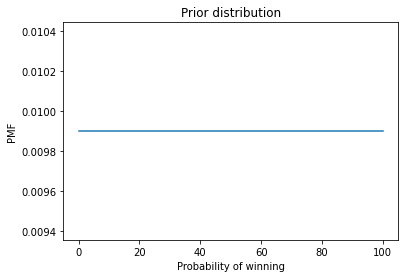

In [5]:
prior.plot()
decorate_bandit('Prior distribution')

## The update function

The following function takes as parameters a Pandas Series that represents the prior distribution and a string that represents the data: either `W` if we won or `L` if we lost.

In [6]:
def update(pmf, data):
    """Likelihood function for Bayesian bandit
    
    pmf: Series that maps hypotheses to probabilities
    data: string, either 'W' or 'L'
    """
    xs = pmf.index
    if data == 'W':
        likelihood = xs / 100
    else:
        likelihood = 1- xs/100
        
    pmf *= likelihood
    pmf /= pmf.sum()

It uses the quantities in the index to compute the likelihood of the data, then updates `pmf` by multiplying by the likelihood and dividing through by the probability of the data.

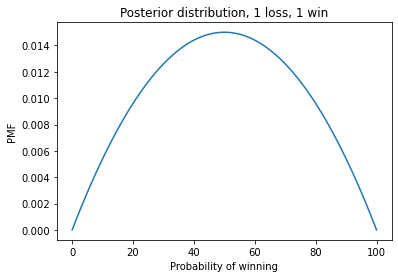

In [7]:
bandit = prior.copy()
update(bandit, 'W')
update(bandit, 'L')
bandit.plot()
decorate_bandit('Posterior distribution, 1 loss, 1 win')

### Exercise

Suppose you play a machine 10 times and win once.  What is the posterior distribution of $x$?

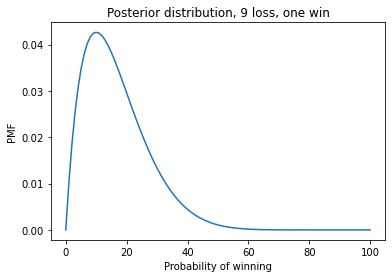

In [8]:
# Solution

bandit = prior.copy()

for outcome in 'WLLLLLLLLL':
    update(bandit, outcome)
    
bandit.plot()
decorate_bandit('Posterior distribution, 9 loss, one win')

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, suppose we have 4 machines with these probabilities:

In [9]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

For purposes of the example, we should assume that we do not know these probabilities.

The function `play` simulates playing one machine once and returns `W` or `L`.

In [10]:
from random import random
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def flip(p):
    """Return True with probability p."""
    return random() < p

def play(i):
    """Play machine i.
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [11]:
for i in range(20):
    outcome = play(3)
    print(outcome, end=' ')

L W L W L L L L L L W L W L W W W L L L 

Now I'll make four copies of the prior to represent our beliefs about the four machines.

In [12]:
beliefs = [prior.copy() for i in range(4)]

This function displays four distributions in a grid.

In [13]:
def plot(beliefs, **options):
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        b.plot(label='Machine %s' % i)
        plt.gca().set_yticklabels([])
        plt.legend()
        
    plt.tight_layout()

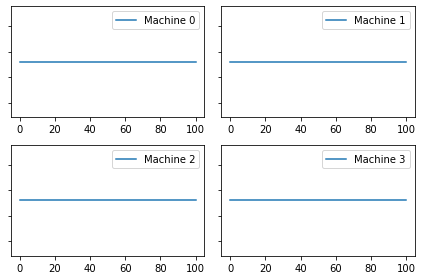

In [14]:
plot(beliefs)

As an example, let's play each machine 10 times, then plot the posterior distributions.  

In [15]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

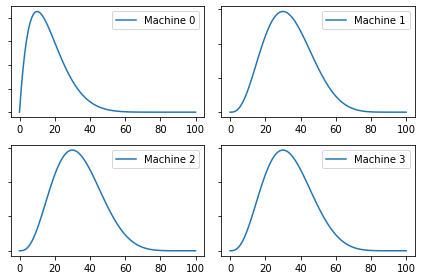

In [16]:
plot(beliefs)

After playing each machine 10 times, we can summarize `beliefs` by printing the posterior mean and credible interval:

In [17]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [18]:
from scipy.interpolate import interp1d

def credible_interval(pmf, prob):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    prob: probability of the interval
    
    return: pair of float
    """
    # make the CDF
    xs = pmf.index
    ys = pmf.cumsum()
    
    # compute the probabilities
    p = (1-prob)/2
    ps = [p, 1-p]
    
    # interpolate the inverse CDF
    options = dict(bounds_error=False,
                   fill_value=(xs[0], xs[-1]), 
                   assume_sorted=True)
    interp = interp1d(ys, xs, **options)
    return interp(ps)

In [19]:
for i, b in enumerate(beliefs):
    print(pmf_mean(b), credible_interval(b, 0.9))

16.68194469884906 [ 2.85950913 35.94118558]
33.33332967399789 [13.01254283 55.93620852]
33.33332967399788 [13.01254283 55.93620852]
33.33332967399788 [13.01254283 55.93620852]


## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that it collects and uses data at the same time.  In other words, it balances exploration and exploitation.

The following function chooses among the machines so that the probability of choosing each machine is proportional to its "probability of superiority".

In [20]:
def pmf_choice(pmf):
    """Draw a random sample from a PMF.
    
    pmf: Series representing a PMF
    
    returns: quantity from PMF
    """
    return np.random.choice(pmf.index, p=pmf)

In [21]:
def choose(beliefs):
    """Use the Bayesian bandit strategy to choose a machine.
    
    Draws a sample from each distributions.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [pmf_choice(b) for b in beliefs]
    return np.argmax(ps)

This function chooses one value from the posterior distribution of each machine and then uses `argmax` to find the index of the machine that chose the highest value.

Here's an example.

In [22]:
choose(beliefs)

3

**Exercise 3:** Putting it all together, fill in the following function to choose a machine, play once, and update `beliefs`:

In [23]:
def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.
    
    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    machine = ____
    
    # play it
    outcome = ____
    
    # update beliefs
    update(____)
    
    if verbose:
        print(machine, outcome, pmf_mean(beliefs[machine]))

In [24]:
# Solution

def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.
    
    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    update(beliefs[machine], outcome)
    
    if verbose:
        print(machine, outcome, pmf_mean(beliefs[machine]))

Here's an example

In [25]:
choose_play_update(beliefs, verbose=True)

3 L 30.769225705357073


## Trying it out

Let's start again with a fresh set of machines and an empty `Counter`.

In [26]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

If we run the bandit algorithm 100 times, we can see how `beliefs` gets updated:

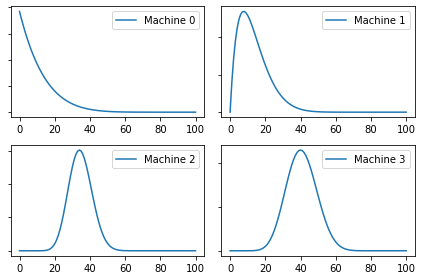

In [27]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [28]:
for i, b in enumerate(beliefs):
    print(pmf_mean(b), credible_interval(b, 0.9))

10.67256304224325 [ 0.         30.40043143]
13.353554678343102 [ 2.1380095  29.18750335]
34.61538461538461 [23.68604026 45.21653114]
40.625 [26.36749222 54.55931154]


The credible intervals usually contain the true values (0.1, 0.2, 0.3, and 0.4).

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to plan, the machines with higher probabilities should get played more often.

In [29]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 7
1 13
2 50
3 30


**Exercise 4:**  Go back and run this section again with a different value of `num_play` and see how it does.

## Summary

The algorithm I presented in this notebook is called [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling).  It is an example of a general strategy called [Bayesian decision theory](https://wiki.lesswrong.com/wiki/Bayesian_decision_theory), which is the idea of using a posterior distribution as part of a decision-making process, usually by choosing an action that minimizes the costs we expect on average (or maximizes a benefit).

In my opinion, this strategy is the biggest advantage of Bayesian methods over classical statistics.  When we represent knowledge in the form of probability distributions, Bayes's theorem tells us how to change our beliefs as we get more data, and Bayesian decisions theory tells us how to make that knowledge actionable.